# CNN Per-Cell Hotspot Classification — Seismic CNN Prediction

**Objective.** For each 1×1 cell in a 50×50 grid, estimate the probability that **at least one earthquake with magnitude ≥ `mag_threshold`** will occur **within the next `horizon_days`**.

**Spec.**
- **Input:** 50×50×1 event-density grid built from the most recent `LOOKBACK` events (optionally time-decayed and log1p-transformed). Labels can be spatially smoothed via Gaussian blur (`blur_sigma`).
- **Output:** 50×50×1 **probability map**: \( p(\text{event} \ge \text{`mag_threshold`} \text{ within `horizon_days`}) \) per cell.
- **Model:** Fully-convolutional CNN (no flatten); final **1×1 Conv + Sigmoid** head for **per-cell binary classification**.
- **Loss:** Binary Cross-Entropy by default; **Focal loss** when `use_focal=True`.
- **Imbalance handling:** Positive-class weighting auto-computed from training labels (`auto_pos_w`) and/or focal loss.
- **Metrics:** **PR-AUC (Average Precision)** and **ROC-AUC** as primaries. Also **Precision, Recall, F1** at a chosen threshold `thr` (defaults to 0.5 if not provided), **confidence histograms**, and qualitative **true/prediction maps**.


### Setup

In [84]:

# Imports & repository path setup
import os
import sys
import json
import datetime as dt
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

NOTEBOOK_DIR: Path = Path().resolve()

REPO_ROOT: Path = NOTEBOOK_DIR if (NOTEBOOK_DIR / "src").exists() else NOTEBOOK_DIR.parent

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# Printing Repository Root and Library Versions

print("Repository root:", REPO_ROOT)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

# Sanity checks
src_exists = (REPO_ROOT / "src").exists()
print("'src' directory found:", src_exists)
if not src_exists:
    print("Could not find a 'src' directory at:", REPO_ROOT / "src")

# Testing whether TensorFlow can see a GPU
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print(f"GPU detected ({len(gpus)}):", [g.name for g in gpus])
else:
    print("No GPU detected by TensorFlow — training will run on CPU.")


Repository root: D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction
TensorFlow version: 2.17.1
NumPy version: 1.26.4
'src' directory found: True
No GPU detected by TensorFlow — training will run on CPU.


### Configuration

In [85]:
# Preview key runtime config values
from src.config import runtime as C

keys = [
    "GRID_SIZE","LOOKBACK","HORIZON_HOURS","LOG1P_INPUT","TIME_DECAY",
    "TRAIN_FRAC","VAL_FRAC","TEST_FRAC","SEED",
    "BATCH_SIZE","EPOCHS","LR","WEIGHT_DECAY","DROPOUT","USE_MIXED_PRECISION",
    "FALLBACK_DATA","ARTIFACTS"
]

for k in keys:
    print(f"{k:16s} =", getattr(C, k))

try:
    hz_days = float(C.HORIZON_HOURS) / 24.0
    print(f"HORIZON_DAYS    = {hz_days:.1f}")
except Exception as e:
    print("Could not derive HORIZON_DAYS from HORIZON_HOURS:", e)

GRID_SIZE        = 50
LOOKBACK         = 50
HORIZON_HOURS    = 43800
LOG1P_INPUT      = True
TIME_DECAY       = 0.0
TRAIN_FRAC       = 0.7
VAL_FRAC         = 0.15
TEST_FRAC        = 0.15
SEED             = 42
BATCH_SIZE       = 64
EPOCHS           = 100
LR               = 0.001
WEIGHT_DECAY     = 0.0001
DROPOUT          = 0.1
USE_MIXED_PRECISION = True
FALLBACK_DATA    = D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\data\processed\earthquakes_with_features.csv
ARTIFACTS        = D:\_4TH_YEAR_1ST_SEMESTER_STUFF\DL\DL Final Assignment\Seismic-GNN-Prediction\artifacts\cnn\map
HORIZON_DAYS    = 1825.0


### Data

#### Load data and preview a sample

In [86]:
from src.data.loading import load_data_map

X_train, y_train, X_val, y_val, X_test, y_test = load_data_map()
print("Shapes:")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val:  ", X_val.shape,   " y_val:  ", y_val.shape)
print("  X_test: ", X_test.shape,  " y_test: ", y_test.shape)

# Sanity Checks: Value Ranges

print("X min/max:", float(X_train.min()), float(X_train.max()))
print("y min/max:", float(y_train.min()), float(y_train.max()))

Shapes:
  X_train: (1159, 50, 50, 1)  y_train: (1159, 50, 50, 1)
  X_val:   (248, 50, 50, 1)  y_val:   (248, 50, 50, 1)
  X_test:  (249, 50, 50, 1)  y_test:  (249, 50, 50, 1)
X min/max: 0.0 3.6888794898986816
y min/max: 0.0 7.099999904632568


### Utilities — imports for metrics & plotting

In [87]:
# Utilities for metrics/plots/loader reloads
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, roc_auc_score


### Helper functions — label binarization, class weights, and example selection

In [88]:
def binarize_labels(y, mag_threshold):
    """Turn per-cell magnitude maps into 0/1 labels for '≥ threshold'."""
    return (y >= mag_threshold).astype("float32")

def pos_weight_from(y_bin):
    """Compute positive class weight for severe imbalance."""
    pos = float(y_bin.sum())
    neg = float(y_bin.size - pos)
    return max(1.0, neg / (pos + 1e-6))

def make_sample_weights(y_bin, pos_weight):
    """Weight positives heavier; shape matches y."""
    w = np.ones_like(y_bin, dtype="float32")
    w[y_bin == 1] = pos_weight
    return w

def pick_example_index(y_true_bin):
    """Pick a test index that actually has positives (fallback random)."""
    idxs = np.where(y_true_bin.sum(axis=(1,2,3)) > 0)[0]
    if len(idxs) == 0:
        return np.random.randint(0, y_true_bin.shape[0])
    return np.random.choice(idxs)


## Helpers (binarize, weights, sampling)

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers

def conv_bn_relu(x, filters, wd=None):
    x = layers.Conv2D(
        filters, 3, padding='same', use_bias=False,
        kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None
    )(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_hotspot_model(input_shape=(50,50,1), dropout=0.10, weight_decay=None):
    """Per-cell sigmoid probs with BN + light skip concat."""
    wd = weight_decay if weight_decay is not None else getattr(C, "WEIGHT_DECAY", 0.0)
    inp = layers.Input(shape=input_shape)

    c1 = conv_bn_relu(inp, 32, wd); c1 = conv_bn_relu(c1, 32, wd)
    x  = layers.SpatialDropout2D(dropout)(c1)
    c2 = conv_bn_relu(x, 64, wd);  c2 = conv_bn_relu(c2, 64, wd)

    x  = layers.Concatenate()([c2, c1])
    out = layers.Conv2D(1, 1, activation='sigmoid')(x)
    model = models.Model(inp, out, name="hotspot_fcn_bn")

    # train_hotspot will recompile with the chosen loss
    lr = getattr(C, "LR", 1e-3)
    wd = getattr(C, "WEIGHT_DECAY", 0.0)
    if hasattr(optimizers, "AdamW"):
        opt = optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    else:
        opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
    return model

build_cnn_heatmap_model = build_hotspot_model


## CNN Backbone and Per-cell Head

In [90]:
# deps & config

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.ndimage import gaussian_filter

from src.config import runtime as C

# Utilities

def pos_weight_from(y_bin):
    """
    Compute positive-class weight from binary labels (0/1) so positives get upweighted.
    pos_w ≈ (negatives / positives). Clipped to a sane range.
    """
    p = float(np.mean(y_bin))
    if p <= 0.0:
        return 1.0
    pos_w = (1.0 - p) / p
    return float(np.clip(pos_w, 1.0, 100.0))

def weighted_bce_pixel(pos_w=5.0):
    """
    Per-pixel Binary Crossentropy with positive class upweighting.
    Works with y_true/y_pred shaped [B, H, W, 1].
    """
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none')
    def loss(y_true, y_pred):
        
        per_pix = bce(y_true, y_pred)
        
        per_pix = tf.expand_dims(per_pix, axis=-1)
        
        w = 1.0 + y_true * (pos_w - 1.0)
        
        return tf.reduce_mean(per_pix * w)
    return loss

def blur_stack(Y, sigma=1.0):
    """
    Blur a stack of [N,H,W,1] maps with a Gaussian to soften sparsity.
    """
    if sigma is None or sigma <= 0:
        return Y.astype('float32')
    Yb = np.empty_like(Y, dtype='float32')
    for i in range(Y.shape[0]):
        Yb[i, ..., 0] = gaussian_filter(Y[i, ..., 0], sigma=float(sigma))
    return np.clip(Yb, 0.0, 1.0)


# Model

def conv_bn_relu(x, filters, wd=None):
    x = layers.Conv2D(
        filters, 3, padding='same', use_bias=False,
        kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None
    )(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def build_cnn_heatmap_model(input_shape=(50,50,1), dropout=0.10, weight_decay=None):
    """
    Per-cell sigmoid probabilities with BatchNorm and a simple skip connection.
    """
    wd = weight_decay if weight_decay is not None else getattr(C, "WEIGHT_DECAY", 0.0)
    inp = layers.Input(shape=input_shape)

    c1 = conv_bn_relu(inp, 32, wd); c1 = conv_bn_relu(c1, 32, wd)
    x  = layers.SpatialDropout2D(dropout)(c1)
    c2 = conv_bn_relu(x, 64, wd);  c2 = conv_bn_relu(c2, 64, wd)

    x  = layers.Concatenate()([c2, c1])  # simple skip
    out = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    model = models.Model(inp, out, name="hotspot_fcn_bn")

    # compile
    lr = getattr(C, "LR", 1e-3)
    wd = getattr(C, "WEIGHT_DECAY", 0.0)
    if hasattr(optimizers, "AdamW"):
        opt = optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    else:
        opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])
    return model

# Fallback
def _fallback_heatmap_model(input_shape, dropout=0.10):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.SpatialDropout2D(dropout)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.SpatialDropout2D(dropout)(x)
    out = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs, out, name="hotspot_cnn_fallback")


# Training 

def train_hotspot(horizon_days=7, mag_threshold=4.5, title="Hotspot ≥M4.5",
                  blur_sigma=1.0, use_focal=False, thr=None):
    """
    Train a pixel-level classifier that outputs P(event ≥ mag_threshold in the horizon)
    for each grid cell.

    NOTE: The true time horizon is whatever was used when building y (C.HORIZON_HOURS).
    The 'horizon_days' argument is for readability; to change it, rebuild labels.
    Expects globals: X_train, X_val, X_test, y_train, y_val, y_test.
    """
    # Binary labels
    y_train_bin = (y_train[..., 0] > 0).astype('float32')[..., None]
    y_val_bin   = (y_val  [..., 0] > 0).astype('float32')[..., None]
    y_test_bin  = (y_test [..., 0] > 0).astype('float32')[..., None]

    # Blur to soften the target
    y_train_t = blur_stack(y_train_bin, sigma=blur_sigma)
    y_val_t   = blur_stack(y_val_bin,   sigma=blur_sigma)
    y_test_t  = blur_stack(y_test_bin,  sigma=blur_sigma)

    # tf.data pipelines
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_t)) \
                              .shuffle(2048, seed=getattr(C,"SEED",42)) \
                              .batch(getattr(C, "BATCH_SIZE", 32), drop_remainder=True) \
                              .prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_t)) \
                              .batch(getattr(C, "BATCH_SIZE", 32), drop_remainder=True) \
                              .prefetch(tf.data.AUTOTUNE)

    # Build model
    try:
        model = build_cnn_heatmap_model(
            input_shape=X_train.shape[1:],
            dropout=getattr(C, 'DROPOUT', 0.10)
        )
    except Exception:
        model = _fallback_heatmap_model(
            input_shape=X_train.shape[1:],
            dropout=getattr(C, 'DROPOUT', 0.10)
        )

    # Loss selection 
    auto_pos_w = pos_weight_from(y_train_bin)
    print(f"[{title}] auto_pos_w = {auto_pos_w:.1f}")
    if use_focal and hasattr(tf.keras.losses, "BinaryFocalCrossentropy"):
        loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0)
    else:
        loss_fn = weighted_bce_pixel(pos_w=float(auto_pos_w))

    # Optimizer
    lr = getattr(C, 'LR', 1e-3)
    wd = getattr(C, 'WEIGHT_DECAY', 0.0)
    if hasattr(tf.keras.optimizers, 'AdamW'):
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    else:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss=loss_fn,
        metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)
    ]

    # Train
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=getattr(C, 'EPOCHS', 50),
        callbacks=callbacks,
        verbose=1
    )

    # Calibrate threshold on validation by F1
    y_val_pred = model.predict(X_val, verbose=0)  # (N,H,W,1)
    if thr is None:
        ths = np.linspace(0.01, 0.8, 40)
        best_f1, best_thr, best_pr = -1.0, 0.5, (0.0, 0.0)
        y_true_val = (y_val_t[..., 0] >= 0.5)
        for t in ths:
            y_hat_v = (y_val_pred[..., 0] >= t)
            tp = np.logical_and(y_hat_v, y_true_val).sum()
            fp = np.logical_and(y_hat_v, ~y_true_val).sum()
            fn = np.logical_and(~y_hat_v, y_true_val).sum()
            prec = tp / (tp + fp + 1e-9)
            rec  = tp / (tp + fn + 1e-9)
            f1   = 2 * prec * rec / (prec + rec + 1e-9)
            if f1 > best_f1:
                best_f1, best_thr, best_pr = f1, float(t), (float(prec), float(rec))
        if best_f1 <= 0:
            pos_rate = float(y_true_val.mean())
            q = max(0.0, min(1.0, 1.0 - pos_rate))
            best_thr = float(np.quantile(y_val_pred, q))
        thr = float(best_thr)

    # Test evaluation at chosen threshold
    y_pred = model.predict(X_test, verbose=0)  
    y_hat  = (y_pred[..., 0] >= thr)
    y_true = (y_test_bin[..., 0] >= 0.5)

    tp = np.logical_and(y_hat, y_true).sum()
    fp = np.logical_and(y_hat, ~y_true).sum()
    fn = np.logical_and(~y_hat, y_true).sum()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)

    # Quick visual on one random test tile
    idx = np.random.randint(0, X_test.shape[0])
    vmax = float(max(y_test_t.max(), y_pred.max()))
    plt.figure(figsize=(12, 4))
    for k,(img,title_) in enumerate([
        (y_test_t[idx, ..., 0], "True"),
        (y_pred[idx, ..., 0],   "Pred"),
        (y_pred[idx, ..., 0] - y_test_t[idx, ..., 0], "Error")
    ]):
        ax = plt.subplot(1, 3, k+1)
        im = ax.imshow(img, vmin=0, vmax=vmax, cmap='viridis')
        ax.set_title(title_)
        ax.axis('off')
    plt.suptitle(f"{title}  |  thr={thr:.2f}  |  P={precision:.3f}  R={recall:.3f}")
    plt.show()

    # Summary metrics on test set
    y_prob_test = y_pred.ravel()
    y_true_test = (y_test_t[..., 0] >= 0.5).ravel()
    ap  = float(average_precision_score(y_true_test, y_prob_test))
    auc = float(roc_auc_score(y_true_test, y_prob_test))
    f1  = float(2 * precision * recall / (precision + recall + 1e-9))

    print(f"[{title}] thr={thr:.3f}  P={precision:.3f}  R={recall:.3f}  F1={f1:.3f}  AP={ap:.3f}  AUC={auc:.3f}")

    info = dict(
        title=title,
        thr=float(thr),
        precision=float(precision),
        recall=float(recall),
        F1=f1,
        AP=ap,
        AUC=auc,
        history=hist.history
    )
    return model, info


## Training Helpers (loss/blur)

[7-day ≥M4.5] auto_pos_w = 100.0
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 731ms/step - binary_accuracy: 0.8492 - loss: 0.5826 - val_binary_accuracy: 0.9839 - val_loss: 0.5907 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - binary_accuracy: 0.9687 - loss: 0.3334 - val_binary_accuracy: 0.9839 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 656ms/step - binary_accuracy: 0.9702 - loss: 0.2452 - val_binary_accuracy: 0.9839 - val_loss: 0.2649 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 707ms/step - binary_accuracy: 0.9702 - loss: 0.1941 - val_binary_accuracy: 0.9839 - val_loss: 0.1583 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 700ms/step - binary_accuracy: 0.9702 - loss: 0.1609 - val_binary_accuracy: 0.9839 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 710ms/step - binary_accuracy: 0.9702 - loss: 0.1363 - val_binary_accuracy: 0.9839 - v

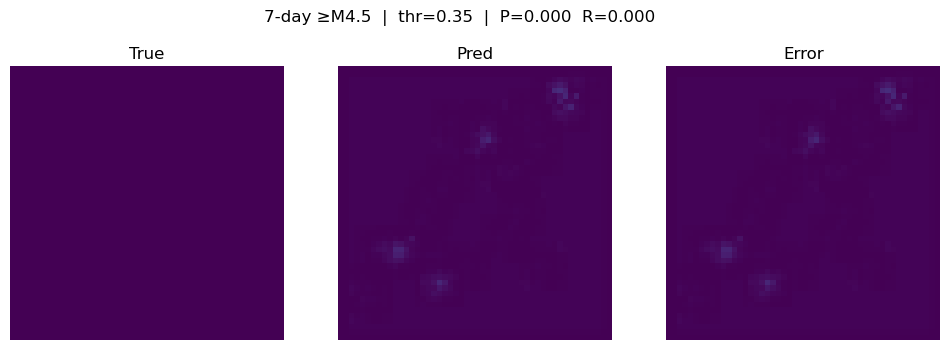

[7-day ≥M4.5] thr=0.347  P=0.000  R=0.000  F1=0.000  AP=0.000  AUC=0.971
[30-day ≥M4.5] auto_pos_w = 100.0
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 669ms/step - binary_accuracy: 0.7079 - loss: 0.7337 - val_binary_accuracy: 0.9839 - val_loss: 0.6618 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 642ms/step - binary_accuracy: 0.9642 - loss: 0.4637 - val_binary_accuracy: 0.9839 - val_loss: 0.5668 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 639ms/step - binary_accuracy: 0.9700 - loss: 0.3633 - val_binary_accuracy: 0.9839 - val_loss: 0.4767 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 640ms/step - binary_accuracy: 0.9702 - loss: 0.2940 - val_binary_accuracy: 0.9839 - val_loss: 0.4169 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 656ms/step - binary_accuracy: 0.9702 - loss: 0.2365 - val_binary_accuracy: 0.9839 - val_loss: 0.3430 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 704ms/step

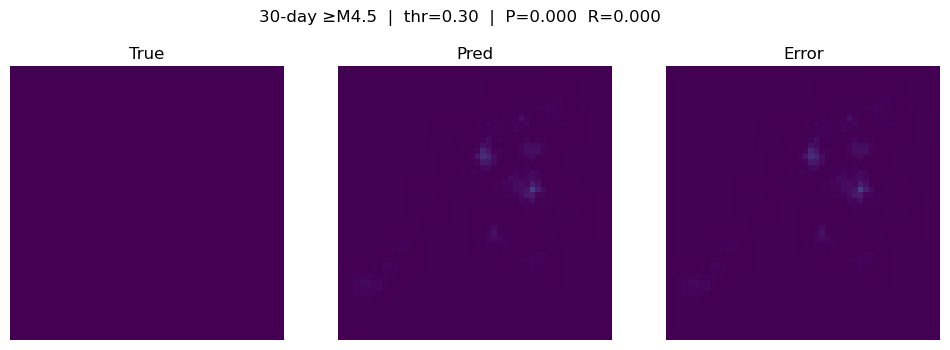

[30-day ≥M4.5] thr=0.303  P=0.000  R=0.000  F1=0.000  AP=0.000  AUC=0.958


In [91]:
model_7d,  info_7d  = train_hotspot(
    horizon_days=7,  mag_threshold=4.5, title="7-day ≥M4.5",
    blur_sigma=1.0, use_focal=False, thr=None
)

model_30d, info_30d = train_hotspot(
    horizon_days=30, mag_threshold=4.5, title="30-day ≥M4.5",
    blur_sigma=1.0, use_focal=False, thr=None
)


## Regional Map Utils (pooling, grid)

## PR/ROC curves for 7‑day and 30‑day

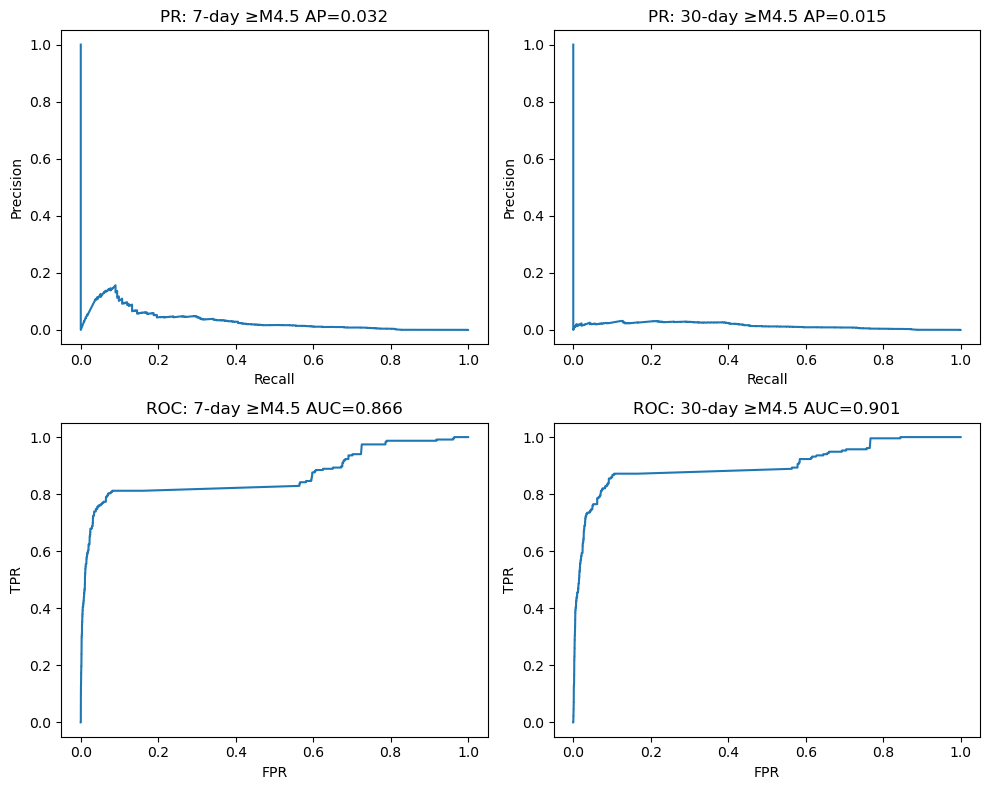

In [92]:
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10,8))
pairs = [(model_7d, '7-day ≥M4.5'), (model_30d, '30-day ≥M4.5')]

for j, (m, lbl) in enumerate(pairs):
    p = m.predict(X_test, verbose=0).ravel()
    t = (y_test[..., 0] > 0).astype('float32').ravel()
    pr, rc, _ = precision_recall_curve(t, p)
    fpr, tpr, _ = roc_curve(t, p)
    ap = average_precision_score(t, p)
    auc = roc_auc_score(t, p)

    axes[0, j].plot(rc, pr)
    axes[0, j].set_title(f'PR: {lbl} AP={ap:.3f}')
    axes[0, j].set_xlabel('Recall')
    axes[0, j].set_ylabel('Precision')

    axes[1, j].plot(fpr, tpr)
    axes[1, j].set_title(f'ROC: {lbl} AUC={auc:.3f}')
    axes[1, j].set_xlabel('FPR')
    axes[1, j].set_ylabel('TPR')

plt.tight_layout()
plt.show()


## Probability histogram (7‑day)

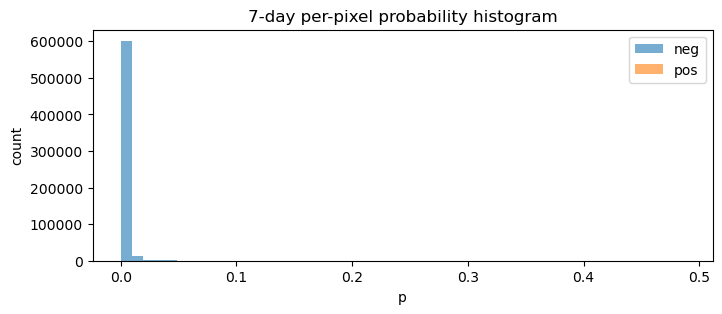

In [93]:
p7 = model_7d.predict(X_test, verbose=0).ravel()
t7 = (y_test[...,0] > 0).astype('float32').ravel()
plt.figure(figsize=(8,3))
plt.hist(p7[t7==0], bins=50, alpha=0.6, label='neg')
plt.hist(p7[t7==1], bins=50, alpha=0.6, label='pos')
plt.legend(); plt.title('7-day per-pixel probability histogram')
plt.xlabel('p'); plt.ylabel('count'); plt.show()

## Regional Risk Model

In [94]:
# Regional Risk Scores

from turtle import title
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Grid-based region map over the 50x50 label map
def make_region_map_grid(H, W, grid_rows, grid_cols):
    """Return integer map (H,W) with region ids in [0, R-1]."""
    region_map = np.zeros((H, W), dtype=np.int32)
    r_h = H // grid_rows
    c_w = W // grid_cols
    rid = 0
    for r in range(grid_rows):
        for c in range(grid_cols):
            r0 = r * r_h
            r1 = (r + 1) * r_h if r < grid_rows - 1 else H
            c0 = c * c_w
            c1 = (c + 1) * c_w if c < grid_cols - 1 else W
            region_map[r0:r1, c0:c1] = rid
            rid += 1
    return region_map 

# pool pixel targets (50x50x1) into region labels

def pool_to_regions(Y_bin, region_map):
    """
    Y_bin: (N, H, W, 1) binary targets per pixel
    region_map: (H, W) ints in [0, R-1]
    return: (N, R) binary label per region (1 if any pixel in region is 1)
    """
    N, H, W, _ = Y_bin.shape
    R = int(region_map.max()) + 1
    out = np.zeros((N, R), dtype='float32')
    for r in range(R):
        mask = (region_map == r)[..., None]  # (H,W,1)
        out[:, r] = (Y_bin * mask).max(axis=(1, 2, 3))
    return out  # (N, R)

# Loss: weight positives only based on y_true
def weighted_bce(pos_w=5.0):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none')
    def loss(y_true, y_pred):
        
        w = 1.0 + y_true * (pos_w - 1.0)  
        l = bce(y_true, y_pred)           
        return tf.reduce_mean(l * w)
    return loss

# Simple region model: CNN backbone -> GAP -> Dense(R, sigmoid)

def build_region_model(num_regions, input_shape, dropout=0.10):
    from tensorflow.keras import regularizers
    wd = getattr(C, "WEIGHT_DECAY", 0.0)

    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None)(inputs)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32, 3, padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.SpatialDropout2D(dropout)(x)

    x = layers.Conv2D(64, 3, padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding='same', use_bias=False,
                      kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Dense(num_regions, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(wd) if wd and wd > 0 else None)(x)
    return models.Model(inputs, out, name="region_risk_cnn_bn")


def train_region_risk(N_years=5, mag_threshold=5.0,
                      grid_rows=6, grid_cols=6,
                      use_kmeans=False, k_clusters=24,
                      title="Regional ≥M5 within N years",
                      use_focal=True, pos_w=None, thr=None, dilate=1):
    """
    Uses your current X_train/y_train/X_val/y_val/X_test/y_test (already loaded elsewhere).
    1) binarize pixel labels
    2) pool to per-region labels
    3) train CNN -> Dense(R, sigmoid)
    """

    # Set long horizon and reload data with project's loader
    from importlib import reload
    C.HORIZON_HOURS = int(24 * 365 * N_years)
    from src.data import loading as loading_mod
    reload(loading_mod)
    from src.data.loading import load_data_map
    X_train, y_train, X_val, y_val, X_test, y_test = load_data_map()

    # Shapes
    H, W = X_train.shape[1], X_train.shape[2]
    region_map = make_region_map_grid(H, W, grid_rows, grid_cols)
    num_regions = int(region_map.max()) + 1

    print(f"[{title}] Shapes:", X_train.shape, y_train.shape)
    print(f"[{title}] num_regions =", num_regions)

    # Binarize pixel-level targets
    y_train_bin = (y_train[..., 0] >= mag_threshold).astype('float32')[..., None]
    y_val_bin   = (y_val  [..., 0] >= mag_threshold).astype('float32')[..., None]
    y_test_bin  = (y_test [..., 0] >= mag_threshold).astype('float32')[..., None]

    # derive automatic positive-class weight from training labels
    auto_pos_w = pos_weight_from(y_train_bin)
    print(f"[{title}] auto_pos_w = {auto_pos_w:.1f}")

    # label dilation to reduce sparsity
    if dilate and dilate > 0:
        from scipy.ndimage import maximum_filter
        y_train_bin = maximum_filter(y_train_bin, size=(1, 1+2*dilate, 1+2*dilate, 1))
        y_val_bin   = maximum_filter(y_val_bin,   size=(1, 1+2*dilate, 1+2*dilate, 1))
        y_test_bin  = maximum_filter(y_test_bin,  size=(1, 1+2*dilate, 1+2*dilate, 1))
        y_train_bin = (y_train_bin > 0).astype('float32')
        y_val_bin   = (y_val_bin   > 0).astype('float32')
        y_test_bin  = (y_test_bin  > 0).astype('float32')

    # Pool to regions
    y_train_R = pool_to_regions(y_train_bin, region_map)
    y_val_R   = pool_to_regions(y_val_bin,   region_map)
    y_test_R  = pool_to_regions(y_test_bin,  region_map)

    print(f"[{title}] y_train_R shape: {y_train_R.shape}  (expect: N_train, {num_regions})")
    print(f"[{title}] y_val_R   shape: {y_val_R.shape}")
    print(f"[{title}] y_test_R  shape: {y_test_R.shape}")

    # Class imbalance: choose a loss
    if use_focal:
        loss_fn = tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0)
        print(f"[{title}] Using Focal loss (gamma=2.0)")
    else:
        if pos_w is None:
            p = float(y_train_R.mean()) + 1e-8    
            pos_w = (1.0 - p) / p
        print(f"[{title}] Positive weight ≈ {pos_w:.1f}")
        loss_fn = weighted_bce(pos_w)

    # tf.data — pairs ONLY (no sample weights/masks)
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_R)) \
                              .shuffle(2048, seed=getattr(C, "SEED", 42)) \
                              .batch(C.BATCH_SIZE, drop_remainder=True) \
                              .prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val_R)) \
                              .batch(C.BATCH_SIZE, drop_remainder=True) \
                              .prefetch(tf.data.AUTOTUNE)

    # Build & compile
    model = build_region_model(num_regions, input_shape=X_train.shape[1:], dropout=getattr(C, "DROPOUT", 0.10))
    lr = getattr(C, "LR", 1e-3)
    wd = getattr(C, "WEIGHT_DECAY", 0.0)
    if hasattr(optimizers, "AdamW"):
        opt = optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    else:
        opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss_fn, metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

    # Train
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)
    ]
    hist = model.fit(train_ds, validation_data=val_ds,
                     epochs=getattr(C, "EPOCHS", 50),
                     callbacks=callbacks, verbose=1)

    # Calibrate threshold on validation, then evaluate
    prob_val  = model.predict(X_val,  verbose=0) 
    if thr is None:
        ths = np.linspace(0.01, 0.5, 25)
        best_f1, best_thr, best_pr = -1.0, 0.5, (0.0, 0.0)
        ytru_val = (y_val_R >= 0.5)
        for t in ths:
            yhat_v = (prob_val >= t)
            tp = np.logical_and(yhat_v, ytru_val).sum()
            fp = np.logical_and(yhat_v, ~ytru_val).sum()
            fn = np.logical_and(~yhat_v, ytru_val).sum()
            prec = tp / (tp + fp + 1e-9)
            rec  = tp / (tp + fn + 1e-9)
            f1   = 2*prec*rec/(prec+rec+1e-9)
            if f1 > best_f1:
                best_f1, best_thr, best_pr = f1, float(t), (float(prec), float(rec))
        if best_f1 <= 0:
            pr = float(ytru_val.mean())
            q  = max(0.0, min(1.0, 1.0 - pr))
            best_thr = float(np.quantile(prob_val, q))
        thr = float(best_thr)
    prob_test = model.predict(X_test, verbose=0)
    yhat = (prob_test >= thr).astype('bool')
    ytru = (y_test_R >= 0.5).astype('bool')

    tp = np.logical_and(yhat, ytru).sum()
    fp = np.logical_and(yhat, ~ytru).sum()
    fn = np.logical_and(~yhat, ytru).sum()
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)

    from sklearn.metrics import average_precision_score, roc_auc_score
    ap  = float(average_precision_score(y_test_R.ravel(), prob_test.ravel()))
    auc = float(roc_auc_score(y_test_R.ravel(), prob_test.ravel()))
    f1  = float(2*precision*recall / (precision + recall + 1e-9))

    print(f"[{title}] thr={thr:.3f}  P={precision:.3f}  R={recall:.3f}  F1={f1:.3f}  AP={ap:.3f}  AUC={auc:.3f}")

    info = dict(
        title=title,
        num_regions=num_regions,
        precision=float(precision),
        recall=float(recall),
        F1=f1, AP=ap, AUC=auc,
        history=hist.history,
        thr=float(thr)
    )
    info["region_map"] = region_map
    info["y_test_R"]   = y_test_R
    info["prob_test"]  = prob_test
    return model, region_map, info


## Regional Evaluation (calibrated threshold)

In [95]:
# Probability per region within 5 years (grid 6x6)
model_region, region_map, info_region = train_region_risk(
    N_years=5, mag_threshold=5.0, grid_rows=6, grid_cols=6,
    use_kmeans=False, k_clusters=24,
    title="Regional ≥M5 within 5 years"
)


[Regional ≥M5 within 5 years] Shapes: (1159, 50, 50, 1) (1159, 50, 50, 1)
[Regional ≥M5 within 5 years] num_regions = 36
[Regional ≥M5 within 5 years] auto_pos_w = 100.0
[Regional ≥M5 within 5 years] y_train_R shape: (1159, 36)  (expect: N_train, 36)
[Regional ≥M5 within 5 years] y_val_R   shape: (248, 36)
[Regional ≥M5 within 5 years] y_test_R  shape: (249, 36)
[Regional ≥M5 within 5 years] Using Focal loss (gamma=2.0)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - binary_accuracy: 0.7214 - loss: 0.1610 - val_binary_accuracy: 0.9690 - val_loss: 0.1704 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - binary_accuracy: 0.9626 - loss: 0.0944 - val_binary_accuracy: 0.9968 - val_loss: 0.1276 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - binary_accuracy: 0.9907 - loss: 0.0550 - val_binary_accuracy: 0.9968 - val_loss: 0.0791 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 396ms/step - binary_accuracy: 0.

##  Regional PR/ROC and histogram (test)

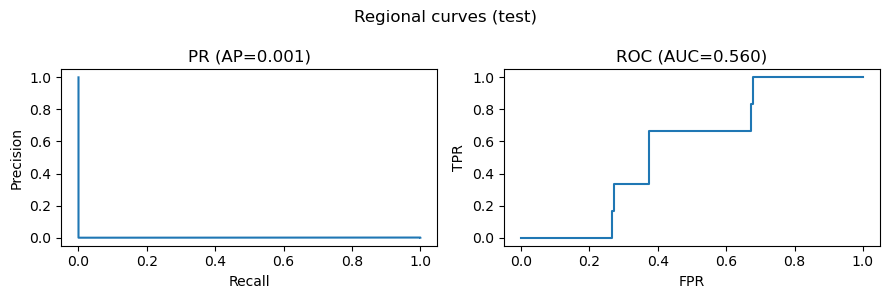

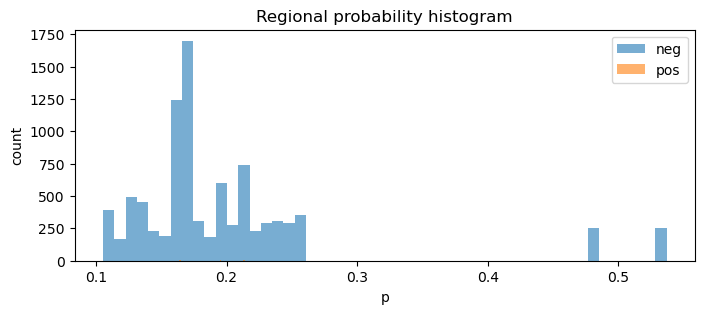

In [96]:
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

prob_test = info_region['prob_test']
y_test_R = info_region['y_test_R']

tt = (y_test_R >= 0.5).astype('float32').ravel()
pp = prob_test.ravel()

pr, rc, _ = precision_recall_curve(tt, pp)
fpr, tpr, _ = roc_curve(tt, pp)
ap = average_precision_score(tt, pp)
auc = roc_auc_score(tt, pp)

fig,ax = plt.subplots(1,2, figsize=(9,3))
ax[0].plot(rc, pr); ax[0].set_title(f'PR (AP={ap:.3f})')
ax[0].set_xlabel('Recall'); ax[0].set_ylabel('Precision')
ax[1].plot(fpr, tpr); ax[1].set_title(f'ROC (AUC={auc:.3f})')
ax[1].set_xlabel('FPR'); ax[1].set_ylabel('TPR')
plt.suptitle('Regional curves (test)'); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.hist(pp[tt==0], bins=50, alpha=0.6, label='neg')
plt.hist(pp[tt==1], bins=50, alpha=0.6, label='pos')
plt.legend(); plt.title('Regional probability histogram')
plt.xlabel('p'); plt.ylabel('count'); plt.show()

## Regional map view (Ten test example)

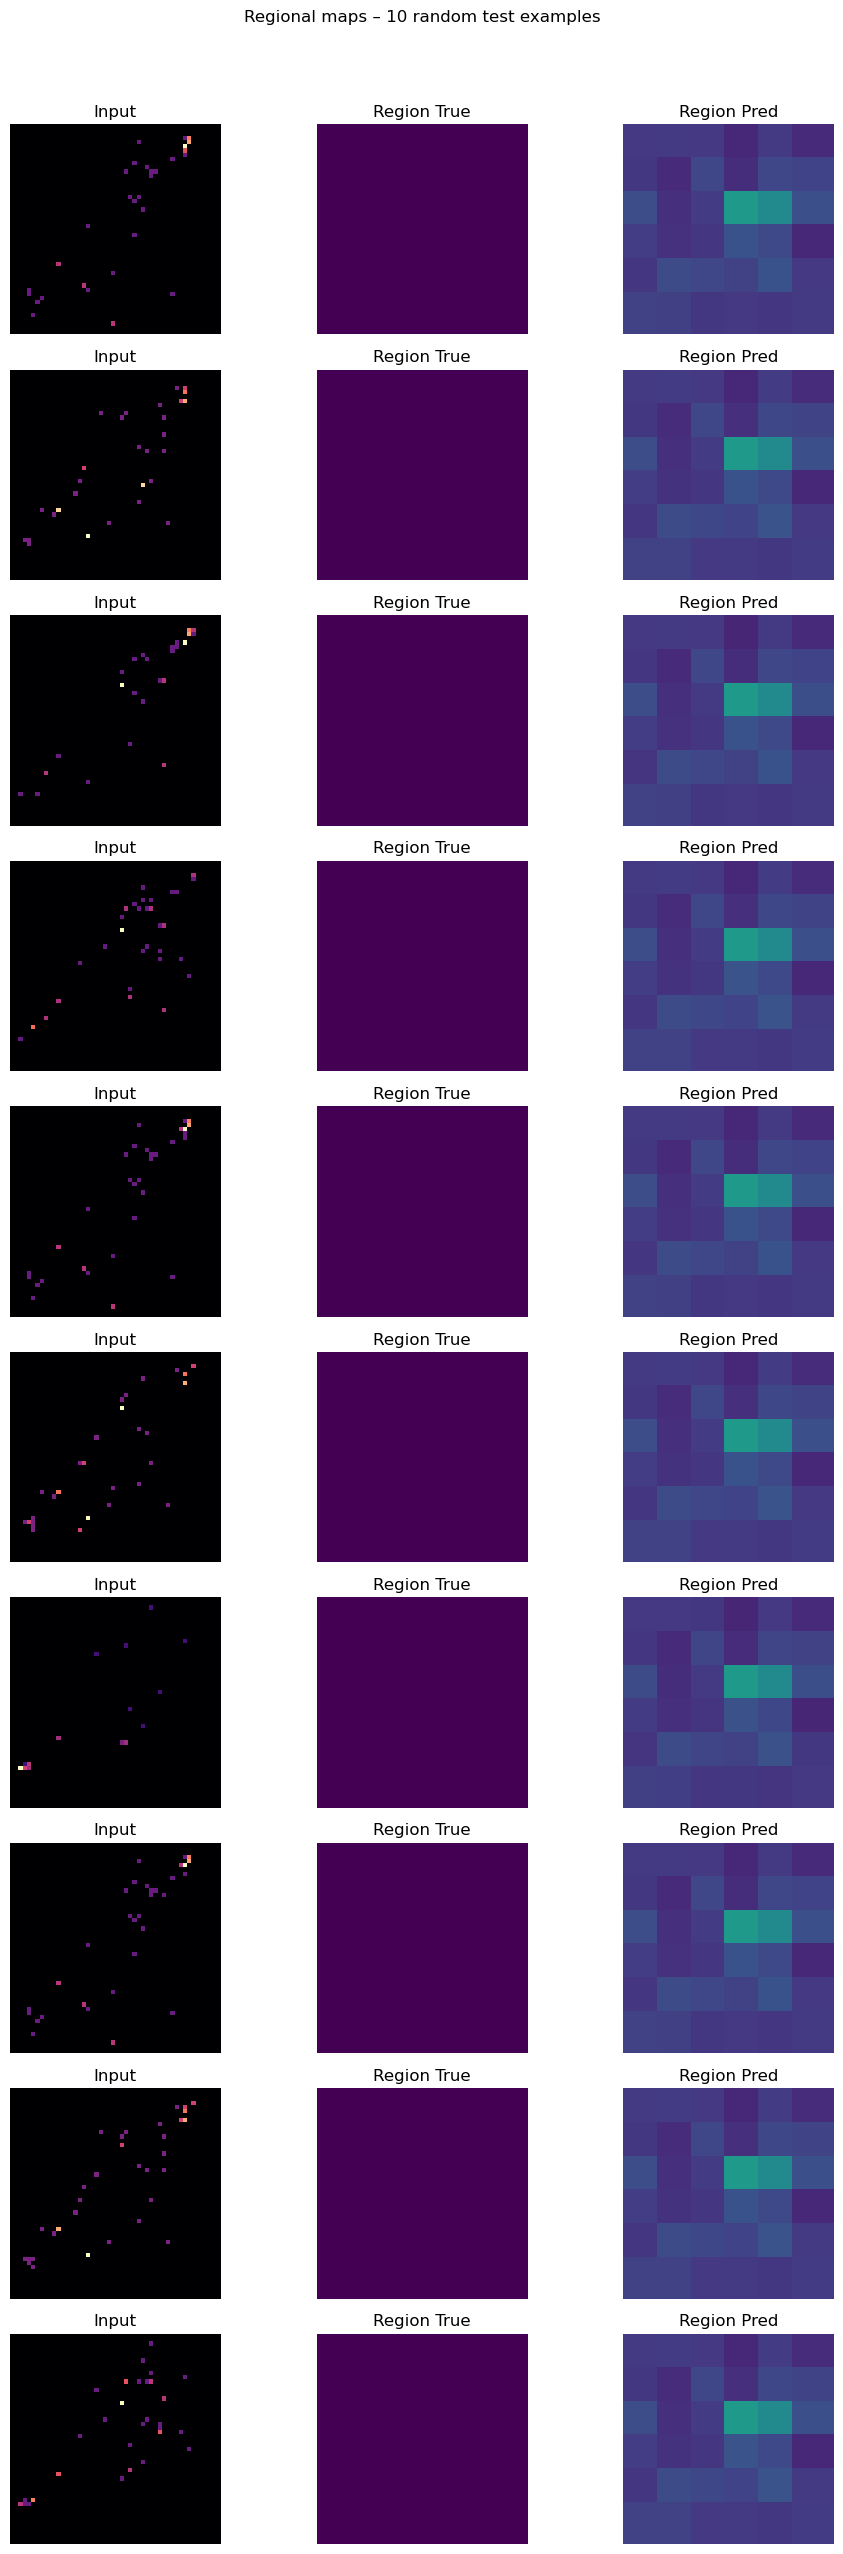

In [97]:
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

rmap = info_region.get('region_map', region_map)

# Number of Examples
n_examples = 10

plt.figure(figsize=(10, n_examples * 2.5)) 

for i in range(n_examples):
    idx = np.random.randint(0, prob_test.shape[0])
    
    grid_pred = prob_test[idx][rmap]
    grid_true = (y_test_R[idx] >= 0.5).astype('float32')[rmap]
    vmax = max(grid_pred.max(), 1.0)
    
   
    plt.subplot(n_examples, 3, 3*i + 1)
    plt.imshow(X_test[idx, ..., 0], cmap='magma')
    plt.title('Input')
    plt.axis('off')
    
    plt.subplot(n_examples, 3, 3*i + 2)
    plt.imshow(grid_true, cmap='viridis', vmin=0, vmax=1)
    plt.title('Region True')
    plt.axis('off')
    
    plt.subplot(n_examples, 3, 3*i + 3)
    plt.imshow(grid_pred, cmap='viridis', vmin=0, vmax=vmax)
    plt.title('Region Pred')
    plt.axis('off')

plt.suptitle('Regional maps – 10 random test examples', y=1.02)
plt.tight_layout()
plt.show()
